In [3]:
import torch
from torch import nn
from torch import autograd
import numpy as np
import pylab as pl
from scipy import integrate

In [5]:
class Block(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()

        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.GELU(),
            #nn.BatchNorm1d(out_features)
        )
    def forward(self, x):
        return self.block(x)


class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            Block(1, 256),
            Block(256, 256),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return torch.view_as_complex(self.layers(x))


In [16]:
class GaussIntegrator:
    def __init__(self, n_points=16):
        self.n_points = n_points
        q, w = np.polynomial.legendre.leggauss(n_points)

        self.q = torch.from_numpy(q).view(-1, 1).float()
        self.w = torch.from_numpy(w).float()

        self.q.requires_grad = True
        self.w.requires_grad = True

    def __call__(self, f, bounds=[-1, 1]):
        if bounds == "inf":
            def g(x): return f(x / (1-x**2)) * (1+x.ravel()**2) / (1-x.ravel()**2)**2
        
        elif bounds[1] == "inf":
            a = bounds[0]
            def g(x): return f(a + x / (1-x)) / (1-x.ravel()**2)

        else:
            b, a = bounds
            s, d = (b+a) * 0.5, (b-a) * 0.5
            def g(x): return f(d*x + s) * d

        return torch.sum(g(self.q).ravel() * self.w)


def hydrogen_potential(x, net):
    return -1/x.ravel() * net(x)


class QuantumLoss():
    def __init__(self, net, potential, integrator=None, bounds="inf"):
        self.net = net
        self.potential = potential

        if integrator is None:
            integrator = GaussIntegrator(n_points=64)
        self.integrator = integrator

        self.bounds = bounds

    def potential_functional(self, x):
        return (self.net(x).conj() * self.potential(x, self.net)).real

    def kinetic_functional(self, x):
        return autograd.functional.jvp(self.net, x, torch.ones_like(x), create_graph=True)[1].abs()**2

    def __call__(self):
        potential_energy = self.integrator(self.potential_functional, self.bounds)
        kinetic_energy = self.integrator(self.kinetic_functional, self.bounds)
        function_norm = self.integrator(lambda x: self.net(x).abs()**2, self.bounds)

        return (potential_energy + kinetic_energy) / function_norm


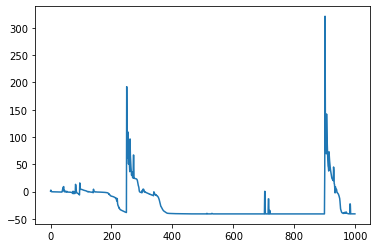

In [23]:
net = MLP()

criterion = QuantumLoss(lambda x: net(x)*(torch.exp(-x**2).ravel()), hydrogen_potential)
optimizer = torch.optim.Rprop(net.parameters())

losses = []
for i in range(1000):
    optimizer.zero_grad()
    loss = criterion()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

pl.plot(losses)

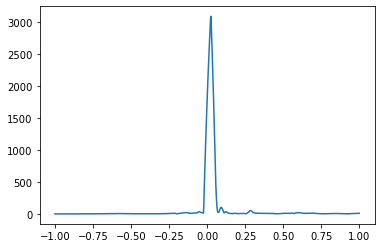

In [24]:
x = torch.linspace(-1, 1, 5280)

with torch.no_grad():
    y = (net(x.view(-1, 1))*torch.exp(-x.ravel()**2)).abs()

pl.plot(x, y)